# Project: Lane Line Detection — Instructions
***
You will assemble a pipeline to detect lane lines. Start on individual images, then apply the same steps to a video (a sequence of frames).

Target output: two lines for the left and right lane boundaries.

Tools:
- Color/brightness selection (optional)
- Region of Interest (ROI) masking
- Grayscale -> Gaussian blur -> Canny edge detection
- Hough Transform to find line segments
- Average/extrapolate segments into two stable lane lines
- Overlay the result on the original frame

Workflow:
1) Get a good result on sample images.
2) Average/extrapolate to extend lane lines.
3) Run the pipeline on the sample videos.

In [5]:
# === Importing dependencies ===
from __future__ import annotations
from dataclasses import dataclass
from moviepy import VideoFileClip # v2 import
from pathlib import Path
from typing import Tuple
from typing import NamedTuple, List, Tuple

import matplotlib.pyplot as plt
import moviepy as _moviepy
import numpy as np, cv2, matplotlib, moviepy
import platform
import sys

In [6]:
# === Environment check (versions) ===
print('Python:', sys.version)
print('Platform:', platform.platform())
try:
    print('NumPy:', np.__version__)
    print('OpenCV:', cv2.__version__)
    print('Matplotlib:', matplotlib.__version__)
    print('MoviePy:', _moviepy.__version__)
except Exception as e:
    raise RuntimeError('Miss dependency? ' + repr(e))

Python: 3.11.13 | packaged by conda-forge | (main, Jun  4 2025, 14:48:23) [GCC 13.3.0]
Platform: Linux-6.6.87.2-microsoft-standard-WSL2-x86_64-with-glibc2.39
NumPy: 1.26.4
OpenCV: 4.10.0
Matplotlib: 3.8.4
MoviePy: 2.0.0


In [7]:
# === Functions & Classes (consolidated) ===
# === UTH Lane Detection — Bootstrap & Config ===

# I/O paths
INP = Path("test_videos")
OUT = Path("test_videos_output")   # processed videos
OUT.mkdir(exist_ok=True)

# Single source of truth for all tunables
# LANE_CONFIG: dataclass for thresholds, ROI, Hough, viz.
# _telemetry(): prints library versions and shows discovered inputs.
# INP, OUT: input videos in test_videos/, outputs in test_videos_output/.

@dataclass
class LaneConfig:
    # Preprocessing
    blur_ksize: int = 5
    canny_low: int = 50
    canny_high: int = 100

    # ROI polygon defined as % of image W/H to avoid hard-coded pixels
    roi_left: float = 0.20
    roi_right: float = 1.00
    roi_top_left: Tuple[float, float] = (0.40, 0.60)   # (x%, y%)
    roi_top_right: Tuple[float, float] = (0.55, 0.60)

    # Hough lines
    rho: int = 1
    theta: float = np.pi / 180
    hough_threshold: int = 40
    min_line_len: int = 10
    max_line_gap: int = 70

    # Viz
    line_thickness: int = 10
    fill_lane: bool = False

    # Temporal smoothing across frames (0 disables)
    smoothing_alpha: float = 0.85

LANE_CONFIG = LaneConfig()

# Quick telemetry — validates toolchain + I/O
def _telemetry():
    print(f"OpenCV: {cv2.__version__}")
    print(f"NumPy : {np.__version__}")
    print("INP   :", INP.resolve())
    print("OUT   :", OUT.resolve())
    if not INP.exists():
        print("WARN  : input folder doesn't exist; create it or point INP to the right place.")
    else:
        vids = sorted([p.name for p in INP.glob("*.mp4")])
        print("Videos:", vids if vids else "(none found)")

_telemetry()
print("LANE_CONFIG   :", LANE_CONFIG)

OpenCV: 4.10.0
NumPy : 1.26.4
INP   : /home/sonhly/workspace/UTH-Lane-Detection/test_videos
OUT   : /home/sonhly/workspace/UTH-Lane-Detection/test_videos_output
Videos: ['Lane-and-Signs.mp4', 'P1_example.mp4', 'challenge.mp4', 'extra-final.mp4', 'raw-lines-example.mp4', 'solidWhiteRight.mp4', 'solidYellowLeft.mp4', 'white-final.mp4', 'yellow-final.mp4']
LANE_CONFIG   : LaneConfig(blur_ksize=5, canny_low=50, canny_high=100, roi_left=0.2, roi_right=1.0, roi_top_left=(0.4, 0.6), roi_top_right=(0.55, 0.6), rho=1, theta=0.017453292519943295, hough_threshold=40, min_line_len=10, max_line_gap=70, line_thickness=10, fill_lane=False, smoothing_alpha=0.85)


In [8]:
def load_rgb(path):
    """
    Load an image from disk as RGB (uint8).
    Uses OpenCV for robust decode, then BGR->RGB.
    """
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"Image not found: {p}")
    bgr = cv2.imread(str(p), cv2.IMREAD_COLOR)
    if bgr is None:
        raise ValueError(f"cv2.imread failed for: {p}")
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

def grayscale(img):
    """
    Convert RGB -> grayscale (uint8).
    Matches the original repo’s style: a thin helper around cv2.cvtColor.
    """
    if img.ndim != 3 or img.shape[2] != 3:
        raise ValueError("grayscale(img) expects an RGB image with 3 channels.")
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# === Module: Gaussian blur ===
# gaussian_blur(img, k): denoise with an odd-sized kernel (3, 5, 7, …).

def gaussian_blur(img, k=5):
    """
    Apply Gaussian blur to a grayscale or RGB image.
    Enforces an odd kernel size. k=5 is a good default.
    """
    k = int(k)
    if k < 1:
        k = 1
    if k % 2 == 0:
        k += 1
    return cv2.GaussianBlur(img, (k, k), 0)

# === Module: edges (Canny) ===
# Purpose: turn blurred grayscale image into a clean edge map.

def canny_edges(img, low=50, high=100, aperture=3, L2gradient=False):
    """
    Module: Edge Detection (Canny)

    - Detect edges using cv2.Canny; tune low/high thresholds for noise vs. signal.
    - Normalize color space (BGR→GRAY) for consistent input.
    - Output is a binary edge map highlighting lane-like structures.
    - Mask region of interest to reduce noise outside the road area.
    - Adjust thresholds empirically per dataset.
    """
    # Ensure single-channel uint8
    if img.ndim == 3 and img.shape[2] == 3:
        # Fallback if caller forgot to grayscale()
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if img.dtype != np.uint8:
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return cv2.Canny(img, low, high, apertureSize=aperture, L2gradient=L2gradient)

# === Module: ROI (polygon + masking) ===

def roi_polygon(h, w, cfg=None):
    """
    Build a trapezoid ROI from percentages of width/height.
    Uses LANE_CONFIG if available; otherwise sane fallbacks.
    Returns: vertices array shaped (1, 4, 2) for cv2.fillPoly
    """
    cfg = cfg or globals().get("LANE_CONFIG", None)
    if cfg is None:
        roi_left, roi_right = 0.20, 1.00
        tl, tr = (0.40, 0.60), (0.55, 0.60)  # (x%, y%)
    else:
        roi_left, roi_right = cfg.roi_left, cfg.roi_right
        tl, tr = cfg.roi_top_left, cfg.roi_top_right

    return np.array([[
        (int(w * roi_left),  h - 1),
        (int(w * tl[0]),     int(h * tl[1])),
        (int(w * tr[0]),     int(h * tr[1])),
        (int(w * roi_right), h - 1),
    ]], dtype=np.int32)

def apply_roi(img, vertices):
    """
    Mask everything outside the polygon.
    Works for 1-channel (edges) or 3-channel images.
    """
    mask = np.zeros_like(img)
    if img.ndim == 3:
        cv2.fillPoly(mask, vertices, (255,) * img.shape[2])
    else:
        cv2.fillPoly(mask, vertices, 255)
    return cv2.bitwise_and(img, mask)

# === Module: Hough line segments ===

def hough_segments(edge_img, rho=1, theta_deg=1.0, threshold=40, min_line_len=20, max_line_gap=80):
    """
    Probabilistic Hough on a single-channel edge image (already ROI-masked).
    Returns array (N,4): [x1, y1, x2, y2]. Empty array if none.
    """
    if edge_img.ndim != 2:
        raise ValueError("hough_segments expects a single-channel edge image")
    theta = np.deg2rad(theta_deg)
    lines = cv2.HoughLinesP(edge_img, rho, theta, threshold,
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    return np.empty((0, 4), dtype=np.int32) if lines is None else lines[:, 0, :]

def draw_segments(rgb_img, segments, color=(255, 0, 0), thickness=2):
    """Overlay raw Hough segments on an RGB image for inspection."""
    out = rgb_img.copy()
    for x1, y1, x2, y2 in segments:
        cv2.line(out, (x1, y1), (x2, y2), color, thickness)
    return out

# === Module: lane consolidation + overlay ===

def split_left_right(segments, w, min_abs_slope=0.5, max_abs_slope=10.0):
    """
    Partition raw Hough segments into left/right buckets.
    - Reject near-horizontal or insane slopes.
    - Use slope sign + x-position to avoid cross-talk.
    Returns: lists of ((x1,y1,x2,y2), weight) where weight = segment length.
    """
    L, R = [], []
    for x1, y1, x2, y2 in segments:
        dx, dy = (x2 - x1), (y2 - y1)
        if dx == 0: 
            continue
        m = dy / dx
        if not np.isfinite(m) or abs(m) < min_abs_slope or abs(m) > max_abs_slope:
            continue
        length = float(np.hypot(dx, dy))
        if m < 0 and max(x1, x2) < w * 0.55:        # left lane tends to be negative slope
            L.append(((x1, y1, x2, y2), length))
        elif m > 0 and min(x1, x2) > w * 0.45:      # right lane tends to be positive slope
            R.append(((x1, y1, x2, y2), length))
    return L, R

def fit_lane_line(points_with_weights, h, w, y_top_ratio=0.60):
    """
    Weighted fit for a single lane line using model x = a*y + b.
    Extrapolates to image bottom and ROI top.
    Returns (x_top, y_top, x_bot, y_bot) or None.
    """
    if len(points_with_weights) < 2:
        return None

    ys, xs, ws = [], [], []
    for (x1, y1, x2, y2), wt in points_with_weights:
        ys += [y1, y2]; xs += [x1, x2]; ws += [wt, wt]
    ys = np.asarray(ys); xs = np.asarray(xs); ws = np.asarray(ws)

    try:
        a, b = np.polyfit(ys, xs, deg=1, w=ws)   # NumPy ≥1.22 supports w
    except TypeError:
        A = np.vstack([ys, np.ones_like(ys)]).T
        W = np.diag(ws / (ws.max() + 1e-6))
        (a, b), *_ = np.linalg.lstsq(W @ A, W @ xs, rcond=None)

    y_bot = h - 1
    y_top = int(h * y_top_ratio)

    # clip to image bounds [0, w-1]
    x_bot = int(np.clip(a * y_bot + b, 0, w - 1))
    x_top = int(np.clip(a * y_top + b,  0, w - 1))
    return (x_top, y_top, x_bot, y_bot)

def draw_lane_overlay(base_rgb, left_line, right_line, *,
                      fill=None, thickness=6, alpha=1.0, cfg=None,
                      stroke=None, outline_color=(255, 255, 255), alpha_fill=0.25,
                      line_color=(255, 0, 0)):
    """
    High-visibility lane render:
      - full-opacity colored lines (both sides = line_color)
      - white outline (stroke) under each line for contrast
      - optional green polygon with light transparency
    """

    if fill is None and cfg is not None:
        fill = getattr(cfg, "fill_lane", False)
    if fill is None:
        fill = False

    # Ensure 3-channel base
    if base_rgb.ndim == 2 or (base_rgb.ndim == 3 and base_rgb.shape[2] == 1):
        base_rgb = cv2.cvtColor(base_rgb, cv2.COLOR_GRAY2RGB)

    out = base_rgb.copy()
    overlay = np.zeros_like(base_rgb)
    AA = cv2.LINE_AA

    def _stroke_line(p1, p2):
        if stroke and stroke > 0:
            cv2.line(overlay, p1, p2, outline_color, thickness + stroke, lineType=AA)
        cv2.line(overlay, p1, p2, line_color, thickness, lineType=AA)

    if left_line:
        _stroke_line((left_line[0], left_line[1]), (left_line[2], left_line[3]))
    if right_line:
        _stroke_line((right_line[0], right_line[1]), (right_line[2], right_line[3]))

    # Lines: keep base 100% bright; blend only the overlay
    out = cv2.addWeighted(out, 1.0, overlay, alpha, 0)

    # Optional polygon fill
    if fill and left_line and right_line:
        poly = np.array([
            [left_line[0],  left_line[1]],
            [right_line[0], right_line[1]],
            [right_line[2], right_line[3]],
            [left_line[2],  left_line[3]],
        ], dtype=np.int32)
        fill_layer = np.zeros_like(base_rgb)
        cv2.fillPoly(fill_layer, [poly], (0, 255, 0))
        out = cv2.addWeighted(out, 1.0, fill_layer, alpha_fill, 0)

    return out


def lanes_from_segments(edge_roi, segments, base_rgb,
                        y_top_ratio=None, thickness=6, fill=None, alpha=1.0):
    """
    Orchestrator for a single frame.
    - splits segments
    - fits left/right lines
    - draws overlay
    Returns: overlay_rgb, (left_line, right_line)
    """
    h, w = edge_roi.shape[:2]
    # derive ROI top from config if available
    if y_top_ratio is None:
        laneConfig = globals().get("LANE_CONFIG", None)
        y_top_ratio = laneConfig.roi_top_left[1] if laneConfig else 0.60

    L, R = split_left_right(segments, w)
    Lfit  = fit_lane_line(L, h, w, y_top_ratio)
    Rfit  = fit_lane_line(R, h, w, y_top_ratio)

    # ensure we have a 3-channel base (in case you're only keeping gray)
    if base_rgb.ndim == 2 or base_rgb.shape[2] == 1:
        base_rgb = cv2.cvtColor(base_rgb, cv2.COLOR_GRAY2RGB)

    # overlay = draw_lane_overlay(base_rgb, Lfit, Rfit, fill=True, thickness=getattr(globals().get("LANE_CONFIG", None), "line_thickness", 10))
    overlay = draw_lane_overlay (base_rgb, Lfit, Rfit,
                        fill=fill,
                        thickness=thickness,
                        alpha=alpha,
                        cfg=globals().get("LANE_CONFIG", None))

    return overlay, (Lfit, Rfit)

# === per-frame lane processor ===
def process_image(frame_rgb, t=None, frame_index=None, **kwargs):
    """
    Input:  RGB frame (MoviePy v2 passes RGB)
    Output: RGB frame with lane & sign overlays
    """
    if frame_rgb.dtype != np.uint8:
        frame_rgb = np.clip(frame_rgb, 0, 255).astype(np.uint8)

    out = frame_rgb.copy()

    # 1) preprocess
    gray  = grayscale(frame_rgb)
    blur  = gaussian_blur(gray, getattr(globals().get("LANE_CONFIG", None), "blur_ksize", 5))
    edges = canny_edges(blur,
                        getattr(globals().get("LANE_CONFIG", None), "canny_low", 50),
                        getattr(globals().get("LANE_CONFIG", None), "canny_high", 100))

    verts = roi_polygon(edges.shape[0], edges.shape[1], cfg=globals().get("LANE_CONFIG", None))
    e_roi = apply_roi(edges, verts)

    # 2) segments via Hough
    segs = hough_segments(
        e_roi,
        rho=getattr(globals().get("LANE_CONFIG", None), "rho", 1),
        theta_deg=1.0,
        threshold=getattr(globals().get("LANE_CONFIG", None), "hough_threshold", 40),
        min_line_len=getattr(globals().get("LANE_CONFIG", None), "min_line_len", 20),
        max_line_gap=getattr(globals().get("LANE_CONFIG", None), "max_line_gap", 80),
    )

    # 3) render lanes first
    out, _ = lanes_from_segments(e_roi, segs, frame_rgb)

    # 4) traffic-sign overlay on top (optional)
    try:
        dets = detect_traffic_signs(out)
        out = draw_detections(out, dets)
    except NameError:
        pass

    return np.ascontiguousarray(out, dtype=np.uint8)

# Module Traffic sign detection (Color + Shape)

In [9]:
"""
Module: Traffic Sign Config
- Define HSV ranges for red and blue traffic signs.
- Define morphological kernel for noise cleaning.
- Define minimum contour area to filter out small objects.
"""

# HSV ranges for red (split into two ranges) and blue
RED1 = ((0, 70, 50),   (10, 255, 255))      # lower red
RED2 = ((170, 70, 50), (180, 255, 255))     # upper red
BLUE  = ((100, 120, 70), (130, 255, 255))   # blue

# Minimum contour area to ignore small noise
MIN_AREA = 600  

# Morphological kernel for mask cleaning
KERNEL = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

# Module: Color Masking & Shape Utilities

In [10]:
"""
Module: Color Masking & Shape Utilities
- Create HSV masks for red and blue colors.
- Use morphology operations to clean up noise.
- Compute contour circularity to evaluate roundness.
- Classify contour shape based on polygon approximation.
"""

def hsv_mask(img_bgr: np.ndarray, lower: Tuple[int,int,int], upper: Tuple[int,int,int]) -> np.ndarray:
    """Return a binary mask for a given HSV range."""
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, np.array(lower), np.array(upper))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, KERNEL)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, KERNEL)
    return mask

def red_mask(img_bgr: np.ndarray) -> np.ndarray:
    """Return mask for red color (two HSV ranges combined)."""
    m1 = hsv_mask(img_bgr, *RED1)
    m2 = hsv_mask(img_bgr, *RED2)
    return cv2.bitwise_or(m1, m2)

def blue_mask(img_bgr: np.ndarray) -> np.ndarray:
    """Return mask for blue color."""
    return hsv_mask(img_bgr, *BLUE)

def contour_circularity(cnt: np.ndarray) -> float:
    """Compute circularity: 4πA / P² (range 0–1, closer to 1 = more circular)."""
    area = cv2.contourArea(cnt)
    per  = cv2.arcLength(cnt, True)
    if per <= 1e-6:
        return 0.0
    return float(4.0 * np.pi * area / (per * per))

def classify_shape(cnt: np.ndarray) -> Tuple[str, float, int]:
    """
    Classify contour shape using polygon approximation and circularity.
    Returns:
        shape_label, circularity, n_vertices
    """
    eps    = 0.02 * cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, eps, True)
    n      = len(approx)
    circ   = contour_circularity(cnt)

    if circ >= 0.75:
        return "circle", circ, n
    if n == 3:
        return "triangle", circ, n
    if n == 4:
        x, y, w, h = cv2.boundingRect(approx)
        ar = w / float(h)
        if 0.8 <= ar <= 1.2:
            return "square", circ, n
        else:
            return "rectangle", circ, n
    if n == 8:
        return "octagon", circ, n
    return "poly", circ, n

In [11]:
"""
Module: Traffic Sign Detection (Color + Shape)
- Build color masks (red, blue) using HSV to handle illumination.
- Find contours, filter by area, and classify shape via polygon approximation.
- Map (color + shape) into coarse labels (STOP / Prohibitory / Mandatory / Warning / Info).
- Score each detection with a simple heuristic for confidence ranking.
"""

from typing import NamedTuple, List, Tuple

class Detection(NamedTuple):
    bbox: Tuple[int, int, int, int]   # x, y, w, h
    label: str                        # STOP / Prohibitory / Mandatory / Warning / Info
    score: float                      # confidence [0..1]
    color: str                        # "red" or "blue"
    vertices: int                     # polygon vertex count

def detect_traffic_signs(img_bgr: np.ndarray) -> List[Detection]:
    """
    Detect traffic signs using color (HSV) + shape heuristics.

    Steps:
    1) Build masks for red and blue colors.
    2) Find external contours in each mask.
    3) Filter by area (MIN_AREA) to remove small noise.
    4) Classify shape (circle, triangle, octagon, square/rectangle, poly).
    5) Map (color, shape) to a coarse sign label.
    6) Compute a simple confidence score based on circularity and fill ratio.

    Returns:
        List[Detection]: sorted by descending score.
    """
    detections: List[Detection] = []

    # 1) Color masks
    masks = [
        ("red",  red_mask(img_bgr)),
        ("blue", blue_mask(img_bgr)),
    ]

    for color, mask in masks:
        # 2) Contours
        cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in cnts:
            # 3) Area filter
            area = cv2.contourArea(cnt)
            if area < MIN_AREA:
                continue

            # 4) Shape classification
            shape, circ, n = classify_shape(cnt)
            x, y, w, h = cv2.boundingRect(cnt)

            # 5) Color+shape → coarse label
            if color == "red":
                if shape == "octagon":
                    label = "STOP"
                elif shape == "triangle":
                    label = "Warning"
                elif shape == "circle":
                    label = "Prohibitory"
                else:
                    label = "Red sign"
            else:  # color == "blue"
                if shape == "circle":
                    label = "Mandatory"
                elif shape in ("square", "rectangle"):
                    label = "Info"
                else:
                    label = "Blue sign"

            # 6) Confidence: combine circularity and fill ratio (simple heuristic)
            fill_ratio = area / float(max(w * h, 1))
            score = float(np.clip(0.5 * circ + 0.5 * fill_ratio, 0.0, 1.0))

            detections.append(Detection((x, y, w, h), label, score, color, n))

    # Sort by confidence (descending)
    detections.sort(key=lambda d: d.score, reverse=True)
    return detections

# Module: Draw Traffic Sign Detections

In [12]:
"""
Module: Draw Traffic Sign Detections
- Draw bounding boxes and labels on top of the original image.
- Use color mapping (red/blue) to reflect the detected sign group.
"""

def draw_detections(img_bgr: np.ndarray, dets: List[Detection]) -> np.ndarray:
    """Draw rectangles and text labels for each detection."""
    out = img_bgr.copy()
    for d in dets:
        x, y, w, h = d.bbox
        color = (0, 0, 255) if d.color == "red" else (255, 0, 0)  # BGR: red or blue

        cv2.rectangle(out, (x, y), (x + w, y + h), color, 5)

        tag = f"{d.label} ({d.score:.2f})"

        cv2.putText(out, tag, (x, max(0, y - 6)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 5, cv2.LINE_AA)
    return out

# BEGIN THE TESTING PHASE HERE

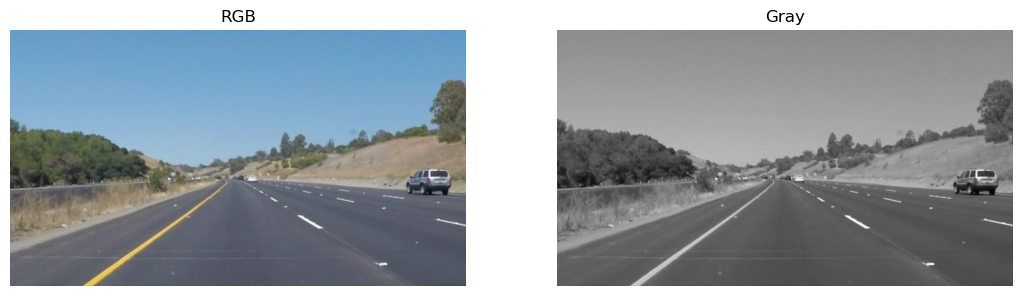

In [13]:
# Test image loading and grayscale

p = Path("test_images/solidYellowCurve.jpg")
assert p.exists(), f"Missing: {p}"

# use your RGB loader (whichever you defined)
rgb  = load_rgb(str(p))   # or: rgb = load_rgb(str(p))
gray = grayscale(rgb)

plt.figure(figsize=(20, 5))

plt.subplot(1,3,1); plt.imshow(rgb); plt.title("RGB"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(gray, cmap="gray"); plt.title("Gray"); plt.axis("off")

plt.show()

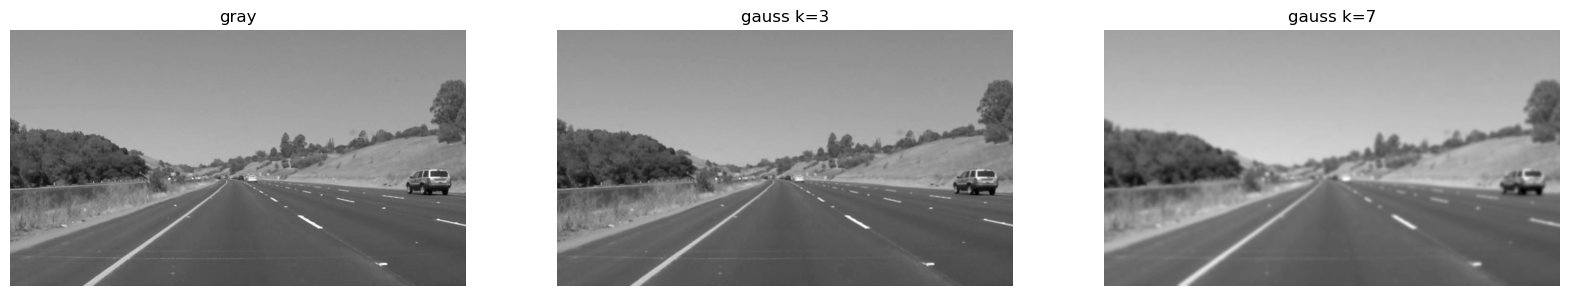

In [15]:
# === Testing for Gaussian blur ===

p = Path("test_images/solidYellowCurve.jpg")
assert p.exists(), f"Missing: {p}"

rgb  = load_rgb(p)
gray = grayscale(rgb)

b3 = gaussian_blur(gray, 3)
b7 = gaussian_blur(gray, 15)

plt.figure(figsize=(20,4))

plt.subplot(1,3,1); plt.imshow(gray, cmap='gray'); plt.title('gray'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(b3,  cmap='gray'); plt.title('gauss k=3'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(b7,  cmap='gray'); plt.title('gauss k=7'); plt.axis('off')

plt.show()

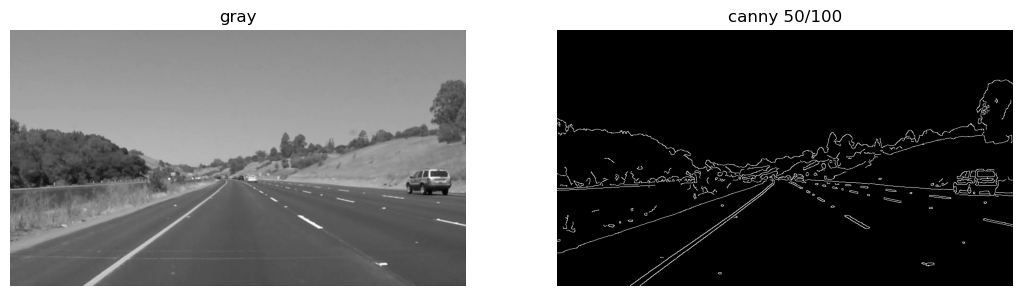

In [16]:
# === Canny test ===

p = Path("test_images/solidYellowCurve.jpg")
assert p.exists(), f"Missing: {p}"

rgb  = load_rgb(p)
gray = grayscale(rgb)
blur = gaussian_blur(gray, 5)

e_fixed = canny_edges(blur, 50, 100) # fixed thresholds

plt.figure(figsize=(20, 4))
plt.subplot(1,3,1); plt.imshow(gray, cmap='gray'); plt.title('gray'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(e_fixed, cmap='gray'); plt.title('canny 50/100'); plt.axis('off')

plt.show()

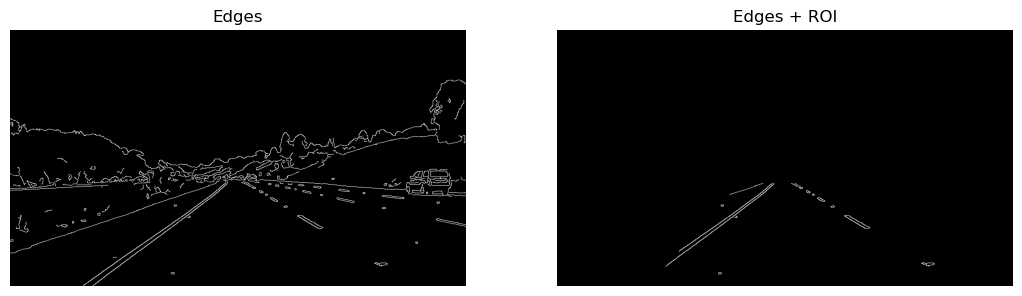

In [15]:
# === Test ROI ===

p = Path("test_images/solidYellowCurve.jpg")
assert p.exists(), f"Missing: {p}"

rgb  = load_rgb(str(p))
gray = grayscale(rgb)
blur = gaussian_blur(gray, 5)
edge = canny_edges(blur, 50, 100)

verts   = roi_polygon(edge.shape[0], edge.shape[1])
edge_roi = apply_roi(edge, verts)

plt.figure(figsize=(20, 4))

plt.subplot(1,3,2); plt.imshow(edge, cmap="gray");plt.title("Edges"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(edge_roi, cmap="gray"); plt.title("Edges + ROI"); plt.axis("off")

plt.show()

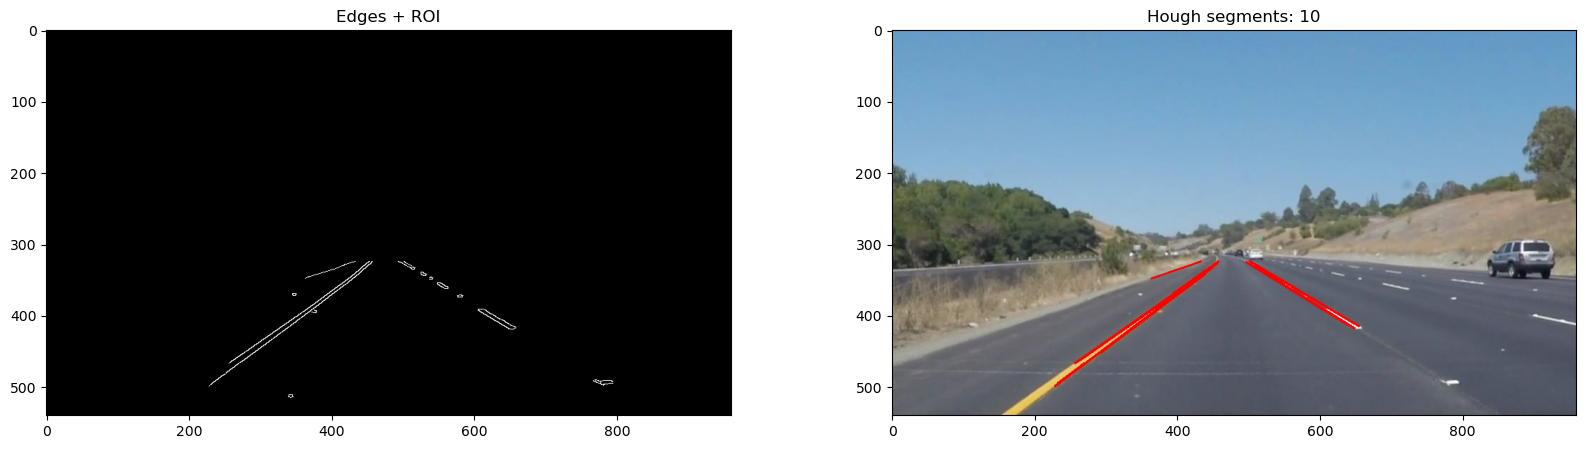

In [16]:
# === Test Hough ===

base_rgb = rgb if "rgb" in globals() else cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

segs = hough_segments(edge_roi, rho=1, theta_deg=1.0, threshold=40, min_line_len=20, max_line_gap=80)
viz  = draw_segments(base_rgb, segs, thickness=2)

plt.figure(figsize=(20, 5))
plt.subplot(1,2,1); plt.imshow(edge_roi, cmap="gray"); plt.title(f"Edges + ROI"); plt.axis("on")
plt.subplot(1,2,2); plt.imshow(viz); plt.title(f"Hough segments: {len(segs)}"); plt.axis("on")

plt.show()

### Module: Hough Transform & Line Fitting


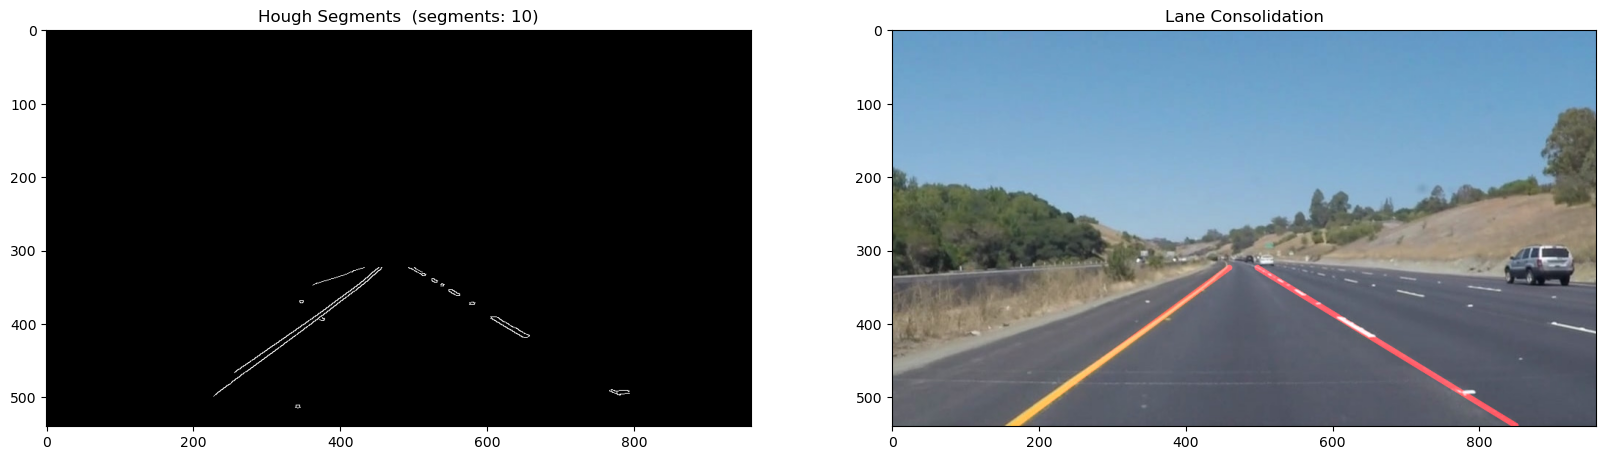

Left line : (459, 324, 166, 539)
Right line: (497, 324, 849, 539)


In [18]:
# === Test lane consolidation + overlay ===

# base frame for drawing
base_rgb = rgb if "rgb" in globals() else cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

# raw segments -> consolidated lanes -> overlay
segs = hough_segments(edge_roi, rho=1, theta_deg=1.0, threshold=40, min_line_len=20, max_line_gap=80)

overlay, (Lfit, Rfit) = lanes_from_segments(edge_roi, segs, base_rgb)

plt.figure(figsize=(20,9))

plt.subplot(1,2,1); plt.imshow(edge_roi, cmap="gray"); plt.title(f"Hough Segments  (segments: {len(segs)})"); plt.axis("on")
plt.subplot(1,2,2); plt.imshow(overlay); plt.title("Lane Consolidation"); plt.axis("on")

plt.show()

print("Left line :", Lfit)
print("Right line:", Rfit)

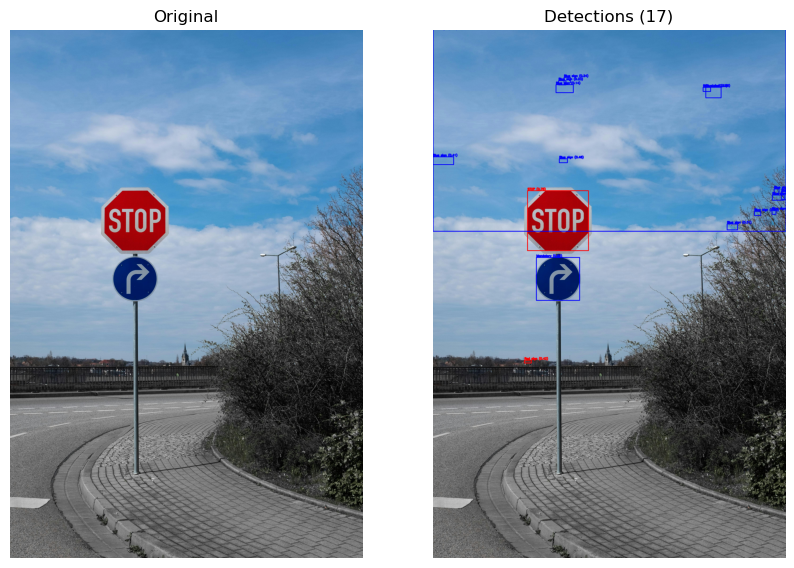

In [19]:
"""
Quick smoke test on a single image.
- Load an image with traffic signs.
- Run detection and draw overlays.
- Visualize original vs. detections side by side.
"""

p = Path("test_images/stop_traffic_sign.jpg")
assert p.exists(), f"Missing image: {p}"

img  = cv2.imread(str(p), cv2.IMREAD_COLOR)
dets = detect_traffic_signs(img)
vis  = draw_detections(img, dets)

plt.figure(figsize=(10,7))
plt.subplot(1, 2, 1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis("off")
plt.subplot(1, 2, 2); plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); plt.title(f"Detections ({len(dets)})"); plt.axis("off")
plt.show()

#dets[:5]  # inspect top-5 detections

# Video processing

In [17]:
"""
# === Module: Video I/O & Frame Extraction ===
Iterate frames, be mindful of FPS and resource cleanup.
"""

inp  = "test_videos/solidWhiteRight.mp4"
outp = "test_videos_output/SolidWhiteRight_out.mp4"

clip_in  = VideoFileClip(inp)
clip_out = clip_in.image_transform(process_image)  # v2 replacement for fl_image

clip_out.write_videofile(
    outp,
    audio=False,
    codec="libx264",
    fps=clip_in.fps,
    preset="medium",
    bitrate="5000k",
)

MoviePy - Building video test_videos_output/SolidWhiteRight_out.mp4.
MoviePy - Writing video test_videos_output/SolidWhiteRight_out.mp4



MoviePy - Done !
MoviePy - video ready test_videos_output/SolidWhiteRight_out.mp4
